In [63]:
import numpy as np
import pandas as pd
import utils
import pymer4.models
import ast
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
import os
import matplotlib.pyplot as plt

In [2]:
exp_measures = pd.read_csv("data/measures.csv")

condition_map = utils.get_nudge_condition_map()
exp_measures["a_values"] = exp_measures.a_values.apply(ast.literal_eval).apply(tuple)
exp_measures["condition"] = pd.Categorical(exp_measures["a_values"].map(condition_map), categories=condition_map.values(), ordered=True)
# exp_measures["condition_coded"] = exp_measures["condition"].cat.codes-2
exp_measures["a_values"] = exp_measures["a_values"].apply(str)
exp_measures["log_RT"] = exp_measures["RT"].apply(np.log)

<AxesSubplot: >

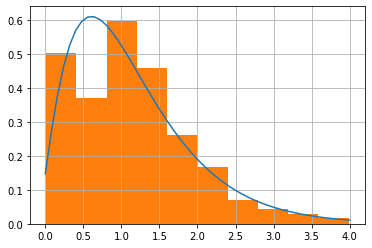

In [3]:
fit_alpha, fit_loc, fit_beta=scipy.stats.gamma.fit(exp_measures[exp_measures.RT<4].RT)
x = np.linspace(0, 4, 51)
y = scipy.stats.gamma.pdf(x-fit_loc, a=fit_alpha, scale=fit_beta)
plt.plot(x, y)
exp_measures[exp_measures.RT<4].RT.hist(density=True)

In [9]:
column_names = {"Estimate": "$b$", "Z-stat": "$z$", "P-val": "$p$", "T-stat": "$t$", "F-stat": "$F$", "2.5_ci": "CI 2.5\%", "97.5_ci": "CI 97.5\%", "NumDF": "df"}
var_names = {"tta_0": "$\\textrm{TTA}_0$",
             "decision:tta_0": "decision:$\\textrm{TTA}_0$",
             "condition:tta_0": "condition:$\\textrm{TTA}_0$",
             "decision:condition:tta_0": "decision:condition:$\\textrm{TTA}_0$",
             "condition1": "Long acceleration",
             "condition2": "Acceleration nudge",
             "condition3": "Deceleration nudge",
             "condition4": "Long deceleration",
             "decision1": "decision"}

# Decision

In [4]:
model_is_go_decision = pymer4.models.Lmer("is_go_decision ~ tta_0 + condition + (1 | subj_id) ", data=exp_measures, family="binomial")
model_is_go_decision_fit = model_is_go_decision.fit(factors={"condition": ["Constant speed", "Long acceleration", "Acceleration nudge", "Deceleration nudge", "Long deceleration"]})
print(model_is_go_decision.coefs)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: is_go_decision~tta_0+condition+(1|subj_id)

Family: binomial	 Inference: parametric

Number of observations: 3800	 Groups: {'subj_id': 19.0}

Log-likelihood: -1543.917 	 AIC: 3101.833

Random effects:

                Name    Var    Std
subj_id  (Intercept)  4.321  2.079

No random effect correlations specified

Fixed effects:

             Estimate     2.5_ci   97.5_ci        SE        OR  OR_2.5_ci  \
(Intercept) -9.370903 -10.758697 -7.983109  0.708071  0.000085   0.000021   
tta_0        1.825554   1.625594  2.025513  0.102022  6.206230   5.081438   
condition1  -0.767809  -1.052470 -0.483147  0.145238  0.464029   0.349074   
condition2  -0.113153  -0.393691  0.167386  0.143134  0.893014   0.674562   
condition3   0.504310   0.222531  0.786089  0.143767  1.655842   1.249234   
condition4   1.477320   1.183432  1.771207  0.149945  4.381186   3.265564   

             OR_97.5_ci      Prob  Prob_2.5_ci  Prob_97.5_ci   

In [5]:
marginal_estimates, comparisons = model_is_go_decision.post_hoc(marginal_vars=["condition"])

P-values adjusted by tukey method for family of 10 estimates


In [194]:
marginal_estimates

,condition,Estimate,2.5_ci,97.5_ci,SE,DF
0,Constant speed,-0.243,-1.200,0.714,0.488,inf
1,Long acceleration,-1.011,-1.969,-0.053,0.489,inf
2,Acceleration nudge,-0.356,-1.313,0.600,0.488,inf
3,Deceleration nudge,0.261,-0.696,1.218,0.488,inf
4,Long deceleration,1.234,0.275,2.193,0.489,inf


In [7]:
comparisons

,Contrast,Estimate,2.5_ci,97.5_ci,SE,DF,Z-stat,P-val,Sig
1,Constant speed - Long acceleration,0.768,0.372,1.164,0.145,inf,5.287,0.000,***
2,Constant speed - Acceleration nudge,0.113,-0.277,0.504,0.143,inf,0.791,0.933,
3,Constant speed - Deceleration nudge,-0.504,-0.896,-0.112,0.144,inf,-3.508,0.004,**
4,Constant speed - Long deceleration,-1.477,-1.886,-1.068,0.150,inf,-9.852,0.000,***
5,Long acceleration - Acceleration nudge,-0.655,-1.050,-0.259,0.145,inf,-4.517,0.000,***
6,Long acceleration - Deceleration nudge,-1.272,-1.674,-0.870,0.147,inf,-8.626,0.000,***
7,Long acceleration - Long deceleration,-2.245,-2.671,-1.819,0.156,inf,-14.388,0.000,***
8,Acceleration nudge - Deceleration nudge,-0.617,-1.010,-0.224,0.144,inf,-4.286,0.000,***
9,Acceleration nudge - Long deceleration,-1.590,-2.001,-1.180,0.151,inf,-10.557,0.000,***
10,Deceleration nudge - Long deceleration,-0.973,-1.376,-0.570,0.148,inf,-6.591,0.000,***


In [10]:
df = model_is_go_decision.coefs.loc[:, ["Estimate", "SE", "Z-stat", "P-val"]]

p_func = lambda p: "{:.2f}".format(p) if p>0.001 else "$<0.001$"

df["P-val"] = df["P-val"].apply(p_func)

styler = df.rename(columns=column_names, index=var_names).style.format(precision=2)

with open('figures/tab_decision.tex', 'w') as tf:
     tf.write(styler.to_latex(
         column_format="rrrrr", position="h", position_float="centering",
         hrules=True, label="tab:decision", caption="Coefficients of the mixed-effects logistic regression describing the final decision as a function of $\\textrm{TTA}_0$ and condition (with Constant speed as the reference category). Participant ID was included as a random intercept."
     )
)

# Response time

Full model with three-way interactions

In [28]:
model_RT = pymer4.models.Lmer("RT ~ 1 + decision + tta_0 + condition + decision:tta_0 + decision:condition + condition:tta_0 + decision:condition:tta_0 + (1 | subj_id)", data=exp_measures, family="gaussian")
model_RT_fit = model_RT.fit(factors={"condition": ["Constant speed", "Long acceleration", "Acceleration nudge", "Deceleration nudge", "Long deceleration"], "decision": ["Stay", "Go"]}, summarize=False)

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.



<AxesSubplot: ylabel='RT'>

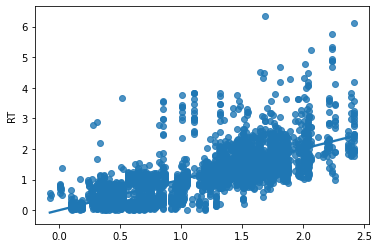

In [60]:
sns.regplot(x=np.asarray(model_RT.fits), y=model_RT.data.RT[~np.isnan(model_RT.data.RT)], fit_reg=True)

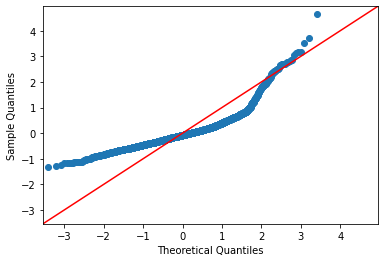

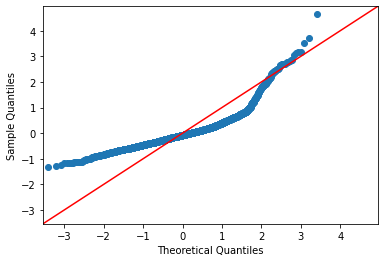

In [65]:
sm.qqplot(np.asarray(model_RT.residuals), line ='45')

In [21]:
model_log_RT = pymer4.models.Lmer("log_RT ~ 1 + decision + tta_0 + condition + decision:tta_0 + decision:condition + condition:tta_0 + decision:condition:tta_0 + (1 | subj_id)", data=exp_measures, family="gaussian")
model_log_RT_fit = model_log_RT.fit(factors={"condition": ["Constant speed", "Long acceleration", "Acceleration nudge", "Deceleration nudge", "Long deceleration"], "decision": ["Stay", "Go"]}, summarize=False)

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.



<AxesSubplot: ylabel='RT'>

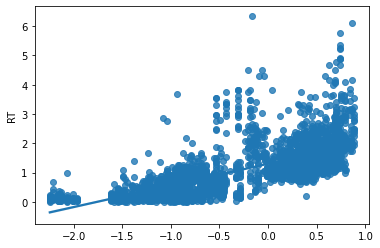

In [67]:
sns.regplot(x=np.asarray(model_log_RT.fits), y=model_log_RT.data.RT[~np.isnan(model_log_RT.data.RT)], fit_reg=True)

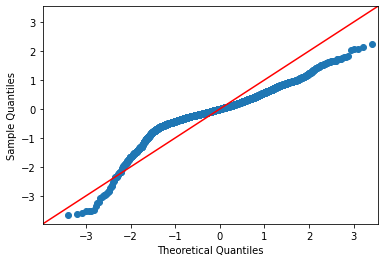

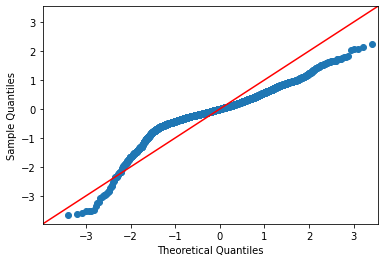

In [66]:
sm.qqplot(np.asarray(model_log_RT.residuals), line ='45')

In [29]:
model_log_RT.coefs

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-0.260523,-0.956261,0.435215,0.354975,1917.505496,-0.733919,0.463088,
decision1,-1.180664,-2.291039,-0.070289,0.566528,2973.804772,-2.084035,0.037242,*
tta_0,0.110830,-0.025284,0.246944,0.069447,2974.393369,1.595893,0.110619,
condition1,0.581427,-0.356191,1.519045,0.478385,2972.943591,1.215395,0.224312,
condition2,0.032286,-0.919827,0.984399,0.485781,2973.128567,0.066462,0.947014,
condition3,0.073003,-0.907381,1.053386,0.500205,2972.958998,0.145945,0.883974,
condition4,0.515303,-0.645053,1.675658,0.592029,2973.810887,0.870401,0.384152,
decision1:tta_0,-0.029694,-0.249124,0.189736,0.111956,2973.596864,-0.265229,0.790851,
decision1:condition1,-0.444081,-2.136438,1.248277,0.863464,2972.963114,-0.514301,0.607079,
decision1:condition2,-0.151878,-1.751790,1.448033,0.816296,2973.046151,-0.186058,0.852412,


In [7]:
model_RT.coefs

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.425898,-0.181480,1.033275,0.309892,2369.125619,1.374342,0.169466,
decision1,-0.180896,-1.159439,0.797647,0.499266,2974.531697,-0.362323,0.717136,
tta_0,0.241597,0.121646,0.361548,0.061201,2975.305526,3.947620,0.000081,***
condition1,1.052044,0.225721,1.878366,0.421601,2973.335895,2.495356,0.012637,*
condition2,0.212729,-0.626362,1.051820,0.428116,2973.585816,0.496895,0.619300,
condition3,0.177525,-0.686486,1.041536,0.440830,2973.356855,0.402706,0.687193,
condition4,1.235526,0.212937,2.258115,0.521739,2974.540496,2.368093,0.017944,*
decision1:tta_0,-0.185064,-0.378443,0.008314,0.098664,2974.246829,-1.875695,0.060795,.
decision1:condition1,-0.773217,-2.264689,0.718256,0.760969,2973.366102,-1.016095,0.309667,
decision1:condition2,0.130104,-1.279892,1.540100,0.719399,2973.477293,0.180851,0.856497,


In [30]:
RT_anova = model_RT.anova()
RT_anova.index = ["decision", "tta_0", "condition", "decision:tta_0", "decision:condition", "condition:tta_0", "decision:condition:tta_0"]

SS Type III Analysis of Variance Table with Satterthwaite approximated degrees of freedom:
(NOTE: Using original model contrasts, orthogonality not guaranteed)


In [23]:
log_RT_anova = model_log_RT.anova()
log_RT_anova.index = ["decision", "tta_0", "condition", "decision:tta_0", "decision:condition", "condition:tta_0", "decision:condition:tta_0"]

SS Type III Analysis of Variance Table with Satterthwaite approximated degrees of freedom:
(NOTE: Using original model contrasts, orthogonality not guaranteed)


In [31]:
RT_anova

,SS,MS,NumDF,DenomDF,F-stat,P-val,Sig
decision,6.699902,6.699902,1,2978.930258,20.093258,7.653882e-06,***
tta_0,10.986597,10.986597,1,2982.707584,32.949217,1.041041e-08,***
condition,2.999869,0.749967,4,2973.874358,2.249180,6.144640e-02,.
decision:tta_0,0.000071,0.000071,1,2977.777531,0.000212,9.883909e-01,
decision:condition,9.882377,2.470594,4,2974.004224,7.409405,6.184003e-06,***
condition:tta_0,4.669410,1.167353,4,2973.998403,3.500934,7.373453e-03,**
decision:condition:tta_0,9.943541,2.485885,4,2974.160004,7.455263,5.679566e-06,***


In [24]:
log_RT_anova

,SS,MS,NumDF,DenomDF,F-stat,P-val,Sig
decision,21.706644,21.706644,1,2977.088373,50.562648,1.439148e-12,***
tta_0,9.523504,9.523504,1,2980.102654,22.183696,2.591024e-06,***
condition,3.033443,0.758361,4,2973.340971,1.766498,1.327523e-01,
decision:tta_0,2.363398,2.363398,1,2976.213888,5.505212,1.902515e-02,*
decision:condition,5.229346,1.307336,4,2973.425526,3.045261,1.619858e-02,*
condition:tta_0,4.261908,1.065477,4,2973.431562,2.481883,4.189584e-02,*
decision:condition:tta_0,5.760032,1.440008,4,2973.539100,3.354301,9.513032e-03,**


In [32]:
df = RT_anova.loc[:, ["SS", "MS", "NumDF", "F-stat", "P-val"]]

p_func = lambda p: "{:.2f}".format(p) if p>0.001 else "$<0.001$"
df["P-val"] = df["P-val"].apply(p_func)

styler = df.rename(columns=column_names, index=var_names).style.format(precision=2)

with open('figures/tab_RT.tex', 'w') as tf:
     tf.write(styler.to_latex(
         column_format="rrrrrrr", position="h", position_float="centering",
         hrules=True, label="tab:RT", caption="ANOVA table based on the mixed-effects linear regression describing response time as a function of decision, $\\textrm{TTA}_0$, and condition."
     )
)

In [25]:
df = log_RT_anova.loc[:, ["SS", "MS", "NumDF", "F-stat", "P-val"]]

p_func = lambda p: "{:.2f}".format(p) if p>0.001 else "$<0.001$"
df["P-val"] = df["P-val"].apply(p_func)

styler = df.rename(columns=column_names, index=var_names).style.format(precision=2)

with open('figures/tab_log_RT.tex', 'w') as tf:
     tf.write(styler.to_latex(
         column_format="rrrrrrr", position="h", position_float="centering",
         hrules=True, label="tab:log_RT", caption="ANOVA table based on the mixed-effects linear regression describing log-transformed response time as a function of decision, $\\textrm{TTA}_0$, and condition."
     )
)

# Post hocs

In [33]:
marginal_estimates, comparisons = model_RT.post_hoc(marginal_vars=["decision"])
# "Cell" means of the ANOVA
marginal_estimates

,decision,Estimate,2.5_ci,97.5_ci,SE,DF
1,Stay,1.639,1.498,1.779,0.067,19.405
2,Go,0.577,0.435,0.718,0.068,20.107


In [34]:
log_RT_marginal_estimates, log_RT_comparisons = model_log_RT.post_hoc(marginal_vars=["decision"])
# "Cell" means of the ANOVA
log_RT_marginal_estimates

,decision,Estimate,2.5_ci,97.5_ci,SE,DF
1,Stay,0.300,0.110,0.489,0.090,18.688
2,Go,-0.993,-1.184,-0.803,0.091,19.170


In [35]:
comparisons

,Contrast,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
1,Stay - Go,1.062,1.006,1.117,0.028,2959.141,37.371,0.0,***


In [37]:
log_RT_comparisons

,Contrast,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
1,Stay - Go,1.293,1.229,1.356,0.032,2983.333,40.017,0.0,***


In [38]:
marginal_estimates, comparisons = model_RT.post_hoc(marginal_vars=["condition"], grouping_vars=["decision"])
# "Cell" means of the ANOVA
marginal_estimates

P-values adjusted by tukey method for family of 10 estimates


,condition,decision,Estimate,2.5_ci,97.5_ci,SE,DF
1,Constant speed,Stay,1.634,1.485,1.783,0.072,25.839
2,Long acceleration,Stay,1.559,1.411,1.707,0.072,25.327
3,Acceleration nudge,Stay,1.509,1.360,1.658,0.072,25.886
4,Deceleration nudge,Stay,1.696,1.546,1.847,0.073,27.418
5,Long deceleration,Stay,1.794,1.633,1.955,0.080,38.005
6,Constant speed,Go,0.528,0.372,0.683,0.076,32.073
7,Long acceleration,Go,0.484,0.320,0.648,0.081,40.762
8,Acceleration nudge,Go,0.562,0.405,0.720,0.077,33.795
9,Deceleration nudge,Go,0.523,0.371,0.676,0.074,28.968
10,Long deceleration,Go,0.787,0.637,0.936,0.073,26.314


In [39]:
log_RT_marginal_estimates, log_RT_comparisons = model_log_RT.post_hoc(marginal_vars=["condition"], grouping_vars=["decision"])
# "Cell" means of the ANOVA
log_RT_marginal_estimates

P-values adjusted by tukey method for family of 10 estimates


,condition,decision,Estimate,2.5_ci,97.5_ci,SE,DF
1,Constant speed,Stay,0.294,0.096,0.491,0.095,23.012
2,Long acceleration,Stay,0.269,0.072,0.466,0.095,22.670
3,Acceleration nudge,Stay,0.250,0.053,0.448,0.095,23.038
4,Deceleration nudge,Stay,0.334,0.135,0.533,0.096,24.057
5,Long deceleration,Stay,0.351,0.142,0.560,0.103,30.865
6,Constant speed,Go,-1.036,-1.239,-0.832,0.099,27.081
7,Long acceleration,Go,-1.153,-1.364,-0.941,0.104,32.593
8,Acceleration nudge,Go,-0.991,-1.196,-0.785,0.100,28.182
9,Deceleration nudge,Go,-0.978,-1.178,-0.777,0.097,25.061
10,Long deceleration,Go,-0.809,-1.007,-0.612,0.096,23.319


In [40]:
comparisons[comparisons.Contrast.str.contains("Long deceleration")]

,Contrast,decision,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
4,Constant speed - Long deceleration,Stay,-0.160,-0.309,-0.011,0.055,2978.218,-2.933,0.028,*
7,Long acceleration - Long deceleration,Stay,-0.235,-0.383,-0.086,0.054,2980.403,-4.314,0.000,***
9,Acceleration nudge - Long deceleration,Stay,-0.285,-0.435,-0.135,0.055,2980.974,-5.184,0.000,***
10,Deceleration nudge - Long deceleration,Stay,-0.098,-0.249,0.054,0.055,2974.938,-1.758,0.399,
14,Constant speed - Long deceleration,Go,-0.259,-0.396,-0.122,0.050,2975.828,-5.154,0.000,***
17,Long acceleration - Long deceleration,Go,-0.303,-0.459,-0.146,0.057,2977.957,-5.275,0.000,***
19,Acceleration nudge - Long deceleration,Go,-0.224,-0.366,-0.083,0.052,2975.561,-4.322,0.000,***
20,Deceleration nudge - Long deceleration,Go,-0.263,-0.393,-0.133,0.047,2974.297,-5.539,0.000,***


In [43]:
log_RT_comparisons[log_RT_comparisons.Contrast.str.contains("Long deceleration")]

,Contrast,decision,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
4,Constant speed - Long deceleration,Stay,-0.057,-0.226,0.112,0.062,2976.564,-0.926,0.887,
7,Long acceleration - Long deceleration,Stay,-0.082,-0.250,0.086,0.062,2978.269,-1.328,0.674,
9,Acceleration nudge - Long deceleration,Stay,-0.101,-0.271,0.070,0.062,2978.717,-1.611,0.491,
10,Deceleration nudge - Long deceleration,Stay,-0.017,-0.189,0.155,0.063,2974.106,-0.272,0.999,
14,Constant speed - Long deceleration,Go,-0.226,-0.382,-0.070,0.057,2974.763,-3.965,0.001,***
17,Long acceleration - Long deceleration,Go,-0.343,-0.521,-0.165,0.065,2976.367,-5.267,0.000,***
19,Acceleration nudge - Long deceleration,Go,-0.181,-0.342,-0.021,0.059,2974.571,-3.078,0.018,*
20,Deceleration nudge - Long deceleration,Go,-0.168,-0.315,-0.021,0.054,2973.641,-3.119,0.016,*


In [44]:
comparisons[comparisons.Contrast.str.contains("Acceleration nudge")]

,Contrast,decision,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
2,Constant speed - Acceleration nudge,Stay,0.125,0.007,0.243,0.043,2974.144,2.884,0.032,*
5,Long acceleration - Acceleration nudge,Stay,0.051,-0.066,0.167,0.043,2973.373,1.180,0.763,
8,Acceleration nudge - Deceleration nudge,Stay,-0.188,-0.311,-0.064,0.045,2978.270,-4.149,0.000,***
9,Acceleration nudge - Long deceleration,Stay,-0.285,-0.435,-0.135,0.055,2980.974,-5.184,0.000,***
12,Constant speed - Acceleration nudge,Go,-0.035,-0.188,0.118,0.056,2973.159,-0.618,0.972,
15,Long acceleration - Acceleration nudge,Go,-0.079,-0.249,0.092,0.062,2974.195,-1.258,0.717,
18,Acceleration nudge - Deceleration nudge,Go,0.039,-0.108,0.186,0.054,2973.776,0.720,0.952,
19,Acceleration nudge - Long deceleration,Go,-0.224,-0.366,-0.083,0.052,2975.561,-4.322,0.000,***


In [45]:
log_RT_comparisons[log_RT_comparisons.Contrast.str.contains("Acceleration nudge")]

,Contrast,decision,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
2,Constant speed - Acceleration nudge,Stay,0.043,-0.091,0.177,0.049,2973.543,0.878,0.905,
5,Long acceleration - Acceleration nudge,Stay,0.019,-0.114,0.151,0.049,2972.970,0.382,0.995,
8,Acceleration nudge - Deceleration nudge,Stay,-0.083,-0.223,0.057,0.051,2976.633,-1.626,0.481,
9,Acceleration nudge - Long deceleration,Stay,-0.101,-0.271,0.070,0.062,2978.717,-1.611,0.491,
12,Constant speed - Acceleration nudge,Go,-0.045,-0.219,0.129,0.064,2972.817,-0.704,0.956,
15,Long acceleration - Acceleration nudge,Go,-0.162,-0.355,0.032,0.071,2973.576,-2.284,0.150,
18,Acceleration nudge - Deceleration nudge,Go,-0.013,-0.180,0.154,0.061,2973.261,-0.215,1.000,
19,Acceleration nudge - Long deceleration,Go,-0.181,-0.342,-0.021,0.059,2974.571,-3.078,0.018,*


In [46]:
comparisons[comparisons.Contrast.str.contains("Deceleration nudge")]

,Contrast,decision,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
3,Constant speed - Deceleration nudge,Stay,-0.063,-0.185,0.060,0.045,2975.095,-1.396,0.630,
6,Long acceleration - Deceleration nudge,Stay,-0.137,-0.258,-0.016,0.044,2977.830,-3.081,0.018,*
8,Acceleration nudge - Deceleration nudge,Stay,-0.188,-0.311,-0.064,0.045,2978.270,-4.149,0.000,***
10,Deceleration nudge - Long deceleration,Stay,-0.098,-0.249,0.054,0.055,2974.938,-1.758,0.399,
13,Constant speed - Deceleration nudge,Go,0.004,-0.139,0.147,0.052,2974.058,0.080,1.000,
16,Long acceleration - Deceleration nudge,Go,-0.040,-0.201,0.122,0.059,2975.242,-0.672,0.963,
18,Acceleration nudge - Deceleration nudge,Go,0.039,-0.108,0.186,0.054,2973.776,0.720,0.952,
20,Deceleration nudge - Long deceleration,Go,-0.263,-0.393,-0.133,0.047,2974.297,-5.539,0.000,***


In [47]:
log_RT_comparisons[log_RT_comparisons.Contrast.str.contains("Deceleration nudge")]

,Contrast,decision,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
3,Constant speed - Deceleration nudge,Stay,-0.040,-0.179,0.099,0.051,2974.235,-0.791,0.933,
6,Long acceleration - Deceleration nudge,Stay,-0.065,-0.203,0.073,0.050,2976.309,-1.284,0.701,
8,Acceleration nudge - Deceleration nudge,Stay,-0.083,-0.223,0.057,0.051,2976.633,-1.626,0.481,
10,Deceleration nudge - Long deceleration,Stay,-0.017,-0.189,0.155,0.063,2974.106,-0.272,0.999,
13,Constant speed - Deceleration nudge,Go,-0.058,-0.220,0.104,0.059,2973.466,-0.976,0.866,
16,Long acceleration - Deceleration nudge,Go,-0.175,-0.358,0.008,0.067,2974.336,-2.609,0.069,.
18,Acceleration nudge - Deceleration nudge,Go,-0.013,-0.180,0.154,0.061,2973.261,-0.215,1.000,
20,Deceleration nudge - Long deceleration,Go,-0.168,-0.315,-0.021,0.054,2973.641,-3.119,0.016,*


# Negative rating

In [10]:
model_rating = pymer4.models.Lmer("is_negative_rating ~ tta_0 + decision + condition +  (1 | subj_id)", data=exp_measures, family="binomial")
# model_rating = pymer4.models.Lmer("is_negative_rating ~ decision + condition + (1 | subj_id) ", data=exp_measures, family="binomial")
model_rating_fit = model_rating.fit(factors={"condition": ["Constant speed", "Long acceleration", "Acceleration nudge", "Deceleration nudge", "Long deceleration"], "decision": ["Stay", "Go"]}, summarize=True)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: is_negative_rating~tta_0+decision+condition+(1|subj_id)

Family: binomial	 Inference: parametric

Number of observations: 3800	 Groups: {'subj_id': 19.0}

Log-likelihood: -590.305 	 AIC: 1196.610

Random effects:

                Name    Var    Std
subj_id  (Intercept)  1.302  1.141

No random effect correlations specified

Fixed effects:


In [22]:
wald_stat = ((model_rating.ranef_var["Var"]/model_rating.ranef_var["Std"])**2).values[0]
scipy.stats.chi2.sf(wald_stat, 1)

0.2539205152358433

In [373]:
df = model_rating.coefs.loc[:, ["Estimate", "SE", "Z-stat", "P-val"]]

p_func = lambda p: "{:.2f}".format(p) if p>0.001 else "$<0.001$"

df["P-val"] = df["P-val"].apply(p_func)

styler = df.rename(columns=column_names, index=var_names).style.format(precision=2)

with open('figures/tab_rating.tex', 'w') as tf:
     tf.write(styler.to_latex(
         column_format="rrrrrr", position="h", position_float="centering",
         hrules=True, label="tab:rating", caption="Coefficients of the mixed-effects logistic regression describing occurrence of the negative rating as a function of $\\textrm{TTA}_0$ and condition (with Constant speed as the reference category). Participant ID was included as a random intercept."
     )
)

In [376]:
marginal_estimates, comparisons = model_rating.post_hoc(marginal_vars=["condition"])
# "Cell" means of the ANOVA
marginal_estimates

P-values adjusted by tukey method for family of 10 estimates


,condition,Estimate,2.5_ci,97.5_ci,SE,DF
0,Constant speed,-5.101,-5.879,-4.323,0.397,inf
1,Long acceleration,-5.161,-5.929,-4.393,0.392,inf
2,Acceleration nudge,-4.583,-5.293,-3.873,0.362,inf
3,Deceleration nudge,-4.310,-5.004,-3.617,0.354,inf
4,Long deceleration,-1.730,-2.303,-1.157,0.292,inf


In [363]:
comparisons

,Contrast,Estimate,2.5_ci,97.5_ci,SE,DF,Z-stat,P-val,Sig
0,Constant speed - Long acceleration,0.060,-0.946,1.066,0.369,inf,0.163,1.000,
1,Constant speed - Acceleration nudge,-0.517,-1.446,0.411,0.340,inf,-1.520,0.549,
2,Constant speed - Deceleration nudge,-0.790,-1.694,0.113,0.331,inf,-2.387,0.119,
3,Constant speed - Long deceleration,-3.371,-4.194,-2.547,0.302,inf,-11.163,0.000,***
4,Long acceleration - Acceleration nudge,-0.578,-1.487,0.332,0.333,inf,-1.732,0.414,
5,Long acceleration - Deceleration nudge,-0.851,-1.735,0.034,0.324,inf,-2.623,0.066,.
6,Long acceleration - Long deceleration,-3.431,-4.238,-2.624,0.296,inf,-11.599,0.000,***
7,Acceleration nudge - Deceleration nudge,-0.273,-1.068,0.522,0.292,inf,-0.937,0.883,
8,Acceleration nudge - Long deceleration,-2.853,-3.551,-2.155,0.256,inf,-11.150,0.000,***
9,Deceleration nudge - Long deceleration,-2.580,-3.242,-1.919,0.242,inf,-10.641,0.000,***
